# Inferential Statistics III - Bayesian

## Introduction

In the last two subunits, you've encountered two schools of thought for performing inference from samples. The Frequentist school calls upon a body of theory established over the past couple of centuries or so. Under certain assumptions and conditions, this allows us to calculate what we would expect to see if an experiment were to be repeated again and again and again. The expected value of the average of a sample is one such statistic we can calculate a result for, even if the originating distribution is far from normal. 

The bootstrap school, on the other hand, literally does (virtually) run that experiment again and again and again and empirically observes the multitude of outcomes. It then empirically calculates a statistic of interest. While this can be for exactly the same statistics that frequentism calculates (e.g. the mean of a sample) this empirical approach can also perform inference on statistics that do not have well known sampling distributions. Because of the requirement to repeat many, many redraws (with replacement) from the sample, this approach only became feasible with modern computing power.

And thus we come to the Bayesian school of inference. Here we frame our probabilities not so much in terms of "how many times would I expect this event to occur if the experiment were to be rerun many times" but rather in terms of "what is my belief in the likelihood of this event occurring?" In a Bayesian probabilistic programming context, we can build models for systems and then let the data tell us how likely certain values for our model parameters are. 

This can be a very useful way to incorporate prior knowledge and deal with limited data. It can just be more than a _little_ fiddly to produce a good model!

### References

   * [Frequentism and Bayesianism: A Practical Introduction](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)
   * [Introduction to Bayesian Inference](https://blogs.oracle.com/datascience/introduction-to-bayesian-inference)
   * [Hands On Bayesian Statistics with Python, PyMC3 & ArviZ](https://towardsdatascience.com/hands-on-bayesian-statistics-with-python-pymc3-arviz-499db9a59501)
   * [Bayesian Modeling Cookbook](https://eigenfoo.xyz/bayesian-modelling-cookbook/)
   * [The Inference Button: Bayesian GLMs made easy with PyMC3](https://twiecki.io/blog/2013/08/12/bayesian-glms-1/)
   * [Estimating Probabilities with Bayesian Modeling in Python](https://towardsdatascience.com/estimating-probabilities-with-bayesian-modeling-in-python-7144be007815)
   
   * [Getting started with PyMC3](https://docs.pymc.io/notebooks/getting_started)
   * [General API Quickstart](https://docs.pymc.io/notebooks/api_quickstart.html)
   * [PyMC3 Plotting](https://docs.pymc.io/api/plots.html)
   * [A “quick” introduction to PyMC3 and Bayesian models, Part I](https://blog.datank.ai/a-quick-introduction-to-pymc3-and-bayesian-models-part-i-65419bdffcd8)
   * [Introduction o PyMC3](https://rlhick.people.wm.edu/stories/bayesian_7.html)
   * [Bayesian Estimation with PyMC3](https://medium.com/@rnbrown/bayesian-estimation-with-pymc3-9906a5214618)
   * [Why do we use HPD...](https://www.researchgate.net/post/Why_do_we_use_Highest_Posterior_Density_HPD_Interval_as_the_interval_estimator_in_Bayesian_Method)

   

## Medical charge data set

For the final mini-project of the stats unit, you'll once again return to the [medical charge data](https://www.kaggle.com/easonlai/sample-insurance-claim-prediction-dataset) you've used for the other mini-projects. Previously, we considered whether we believed that the actual (average) non-insured charge had fallen below a certain threshold.

The hospital is now reviewing its financial resiliency plan, which requires a model for revenue under a range of conditions that include the number of patients treated. Its current model is based on a confidence interval for the mean, and scaling that by different numbers of patients for each scenario. This approach has a number of limitations, most acutely the breakdown of the central limit theorem for low patient volumes; the current model does not do a good job of reflecting the variability in revenue you would see as the number of cases drops.

A bootstrap approach would return samples of the same size as the original. Taking subsamples would restrict the sampling to the values already present in the original sample and would not do a good job of representing the actual variability you might see. What is needed is a better model of individual charges.

So the problem here is that we want to model the distribution of individual charges and _we also really want to be able to capture our uncertainty about that distribution_ so we can better capture the range of values we might see. This naturally leads us to a powerful, probabilistic approach — we'll use the pymc3 library to perform Bayesian inference.

### Loading the data and performing an initial view

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
from scipy.stats import gamma
# there has been some incompatibilty between theano (pymc3) and numpy.
# if you encounter an error with the latest packages from anaconda, 
# then the included package-list-txt should allow you to create a conda 
# environment with compatible packages.

In [2]:
medical = pd.read_csv('data/insurance2.csv')

In [3]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In [4]:
insurance = medical.charges[medical.insuranceclaim == 1]
no_insurance = medical.charges[medical.insuranceclaim == 0]
n_ins = len(insurance)
n_no_ins = len(no_insurance)

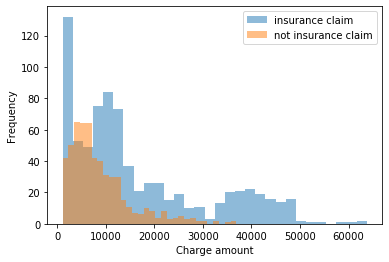

In [5]:
_ = plt.hist(insurance, bins=30, alpha=0.5, label='insurance claim')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='not insurance claim')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

We may suspect from the above that there is some sort of exponential-like distribution at play here. The charges that were not insurance claims seem most like this. The insurance claim charges may possibly be multimodal. The gamma distribution may be applicable and we could test this for the distribution of charges that weren't insurance claims first. Developing our new method for the easiest looking case first is a common and sound approach that can demonstrate a minimum viable solution/product and get, or keep, stakeholders on board.

"In probability theory and statistics, the gamma distribution is a two-parameter family of continuous probability distributions."



### Initial parameter estimation

An initial guess for the gamma distribution's $\alpha$ and $\beta$ parameters can be made as described [here](https://wiki.analytica.com/index.php?title=Gamma_distribution).

<blockquote>
    The Gamma distribution is a continuous, positive-only, unimodal distribution that encodes the time required for «alpha» events to occur in a Poisson process with mean arrival time of «beta»

Use the Gamma distribution with «alpha» > 1 if you have a sharp lower bound of zero but no sharp upper bound, a single mode, and a positive skew. The LogNormal distribution is also an option in this case. Gamma() is especially appropriate when encoding arrival times for sets of events. A gamma distribution with a large value for «alpha» is also useful when you wish to use a bell-shaped curve for a positive-only quantity.

The gamma distribution is bounded below by zero (all sample points are positive) and is unbounded from above. It has a theoretical mean of alpha*beta and a theoretical variance of alpha*beta^2. When «alpha» > 1, the distribution is unimodal with the mode at (alpha - 1)*beta. An exponential distribution results when alpha = 1. As α→∞ , the gamma distribution approaches a normal distribution in shape.

*Parameter Estimation*

Suppose X contains sampled historical data indexed by I. To estimate the parameters of the gamma distribution that best fits this sampled data, the following parameter estimation formulae can be used:

```
alpha := Mean(X, I)^2/Variance(X, I)
beta  := Variance(X, I)/Mean(X, I)
```
</blockquote>

See also: [How to find out the alpha and beta parameter of Gamma distribution](https://www.researchgate.net/post/how_to_find_out_the_alpha_and_beta_parameter_of_Gamma_distribution)

<blockquote>
obtain the mean and variance of the data in study, develop a system of equations with the mean and variance.

```
mean = alpha * beta
variance = alpha * beta ^2
```
</blockquote>

In [6]:
alpha_est = np.mean(no_insurance)**2 / np.var(no_insurance)
beta_est = np.var(no_insurance) / np.mean(no_insurance)
alpha_est, beta_est

(1.8759059725250895, 4702.486170152818)

### Initial simulation

Let's draw the same number of random variates from this distribution and compare to our observed data.

In [7]:
seed(47)
no_ins_model_rvs = gamma(alpha_est, scale=beta_est).rvs(n_no_ins)

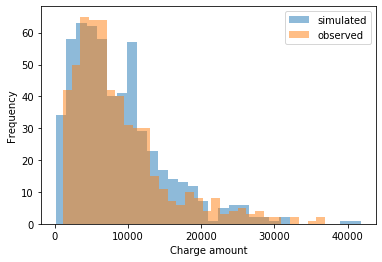

In [8]:
_ = plt.hist(no_ins_model_rvs, bins=30, alpha=0.5, label='simulated')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='observed')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

Well it doesn't look too bad! We're not a million miles off. But can we do better? We have a plausible form for the distribution of charge amounts and potential values for that distribution's parameters so we can already draw random variates from that distribution to perform simulations. But we don't know if we have a _best_ estimate for the population parameters, and we also only have a single estimate each for $\alpha$ and $\beta$; we aren't capturing our uncertainty in their values. Can we take a Bayesian inference approach to estimate the parameters?

### Creating a PyMC3 model

In [9]:
# PyMC3 Gamma seems to use rate = 1/beta
rate_est = 1/beta_est
### Except when that value is so close to zero it causes errors!

# Initial parameter estimates we'll use below
alpha_est, beta_est, rate_est

(1.8759059725250895, 4702.486170152818, 0.00021265346963636103)

__Q:__ You are now going to create your own PyMC3 model!
1. Use an [exponential](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Exponential) prior for alpha. Call this stochastic variable `alpha_`.
2. Similarly, use an exponential prior for the rate ([$1/\beta$](https://wiki.analytica.com/index.php?title=Gamma_distribution)) parameter in PyMC3's [Gamma](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Gamma). Call this stochastic variable `rate_` (but it will be supplied as `pm.Gamma`'s `beta` parameter). Hint: to set up a prior with an exponential distribution for $x$ where you have an initial estimate for $x$ of $x_0$, use a scale parameter of $1/x_0$.
5. Create your Gamma distribution with your `alpha_` and `rate_` stochastic variables and the observed data.
6. Perform 10000 draws.

Hint: you may find it helpful to work backwards. Start with your `pm.Gamma`, and note the required stochastic variables `alpha` and `beta`. Then, before that, you need to create those stochastic variables using `pm.Exponential` and the correct parameters.


**_A:_** 

Ref: [Getting started with PyMC3](https://docs.pymc.io/notebooks/getting_started)

Ref: [Introduction to Bayesian Modeling with PyMC3](https://juanitorduz.github.io/intro_pymc3/)

**Issue**

If I calculate 
```
rate_est = 1/beta_est
```
and then run the code above with 
```
    # alpha
    alpha_ = pm.Exponential('alpha_', alpha_est)

    # beta
    rate_ = pm.Exponential('rate_', rate_est)
```
I get errors. 

```
ValueError                                Traceback (most recent call last)
ValueError: Mass matrix contains zeros on the diagonal. 
The derivative of RV `alpha__log__`.ravel()[0] is zero.
```

-----

(cf: [stackoverflow post](https://stackoverflow.com/questions/58160291/pymc3-nuts-sampler-whats-happning-here)) and [this post](https://discourse.pymc.io/t/help-with-fitting-gamma-distribution/2630)

> The zero problem could be because you are sampling zeros from exponential distribution.

> ... an exponential prior and during the sampling it may sample 0s (which leads to division by 0 --> inf).

```
rate_est: 0.00021265346963636103

1/rate_est: 4702.486170152818
```

I can believe I'd potentially be sampling zeros from the exponential distribution if I start with rate_est

---
Referring to [Introduction to Bayesian Modeling with PyMC3](https://juanitorduz.github.io/intro_pymc3/)

```
𝑎>0  is the shape parameter and 𝑏>0 is the rate parameter
```

Apparently, `b` is also equivalent to `1/scale` if we use `scipy.sats.gamma.pdf`

b is > 0. 1/b is too close to 0.

Instead of setting `rate_est = 1/beta_est` and then passing `1/rate_est` (which is just `beta_est` after all), just pass in `beta_est`.

**Code**

In [10]:
basic_model = pm.Model()

with basic_model: 

    # Priors for unknown model parameters

    # alpha
    alpha_ = pm.Exponential('alpha', alpha_est)

    # beta
    rate_ = pm.Exponential('rate', beta_est)

    g = pm.Gamma('g', alpha=alpha_, beta=rate_, observed=no_insurance)
    
    trace = pm.sample(10000, nuts_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rate, alpha]
Sampling 2 chains: 100%|█████████████| 21000/21000 [00:21<00:00, 956.48draws/s]
The number of effective samples is smaller than 25% for some parameters.


When the code runs...

**Alert** If you get a warning about acceptance probability not matching the target, and that it's around 0.88 when it should be close to 0.8, don't worry. We encourage you to read up on this and see if you can adjust the parameters and/or arguments to pm.sample, but if your model runs without any additional warnings or errors then you should be doing great!

Reading up about the acceptance warning ([here](https://www.quantopian.com/posts/pyfolio-bayesian-tearsheet-how-to-increase-the-number-of-tuning-steps)) I found

<blockquote>
Adrian Seyboldt Jun 7, 2018

Hi, one of the pymc3 developers here :-)<br>
...
<br>
In this case however I really wouldn't worry about it, the acceptance probability is higher than the target. That means that we waste some time in this calculation, but it only takes a couple of seconds anyway...
</blockquote>

Huh.

See also [this post](https://stats.stackexchange.com/questions/388230/pymc3-acceptance-probabilities-and-divergencies-after-tuning) which suggests using
```
pm.sample(..., nuts_kwargs=dict(target_accept=0.95))
```

So I added something like that to the code and the alert disappeared.

-----------------------

__Q:__ Explore your posteriors for $\alpha$ and $\beta$ (from the trace).
* Calculate the 95% credible interval for $\alpha$ and $\beta$.
* Plot your posterior values of $\alpha$ and $\beta$ (both line plots and histograms). 
* Mark your CIs on the histograms.
* Do they look okay? What would bad plots look like?

__A:__ Exploring...

references: 
  * [Hands On Bayesian Statistics with Python, PyMC3 & ArviZ](https://towardsdatascience.com/hands-on-bayesian-statistics-with-python-pymc3-arviz-499db9a59501)

In [11]:
# Calculate the 95% credible interval for  𝛼  and  𝛽 .
# look up Bayesian Credible Interval
# pymc3.stats.hpd() looks promising
help(pm.stats.hpd)

Help on function hpd in module pymc3.stats:

hpd(pymc3_obj, *args, **kwargs)
    Calculate highest posterior density (HPD) of array for given alpha. The HPD is the
    minimum width Bayesian credible interval (BCI).
    
    This function assumes the posterior distribution is unimodal:
    it always returns one interval per variable.
    
    :Arguments:
      x : Numpy array
          An array containing MCMC samples
      alpha : float
          Desired probability of type I error (defaults to 0.05)
      transform : callable
          Function to transform data (defaults to identity)



In [12]:
# Calculate the 95% credible interval for  𝛼  and  𝛽 .
pm.stats.hpd(trace)

{0: {'alpha_log__': array([0.68065715, 0.89557736]),
  'rate_log__': array([-8.41498494, -8.17019651]),
  'alpha': array([1.97517529, 2.4487492 ]),
  'rate': array([0.00022106, 0.00028241])},
 1: {'alpha_log__': array([0.68063631, 0.89631285]),
  'rate_log__': array([-8.42076791, -8.18004107]),
  'alpha': array([1.96924229, 2.44380726]),
  'rate': array([0.00022021, 0.00028015])}}

In [13]:
# Alternate method

alpha_ci = np.percentile(trace['alpha'], [2.5, 97.5])
rate_ci = np.percentile(trace['rate'], [2.5, 97.5])

print("alpha CI:", alpha_ci)
print("rate CI:", rate_ci)



alpha CI: [1.97103294 2.44675222]
rate CI: [0.00022031 0.00028109]


In [14]:
# Plot your posterior values of  𝛼  and  𝛽  (both line plots and histograms).
# pymc3.plots.plot_posterior() looks promising
help(pm.plots.plot_posterior)

Help on function plot_posterior in module arviz.plots.posteriorplot:

plot_posterior(data, var_names=None, coords=None, figsize=None, textsize=None, credible_interval=0.94, round_to: Union[int, NoneType] = None, point_estimate='mean', group='posterior', rope=None, ref_val=None, kind='kde', bw=4.5, bins=None, ax=None, **kwargs)
    Plot Posterior densities in the style of John K. Kruschke's book.
    
    Parameters
    ----------
    data : obj
        Any object that can be converted to an az.InferenceData object
        Refer to documentation of az.convert_to_dataset for details
    var_names : list of variable names
        Variables to be plotted, two variables are required.
    coords : mapping, optional
        Coordinates of var_names to be plotted. Passed to `Dataset.sel`
    figsize : tuple
        Figure size. If None it will be defined automatically.
    textsize: float
        Text size scaling factor for labels, titles and lines. If None it will be autoscaled based
       

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1147c4d68>,
      dtype=object)

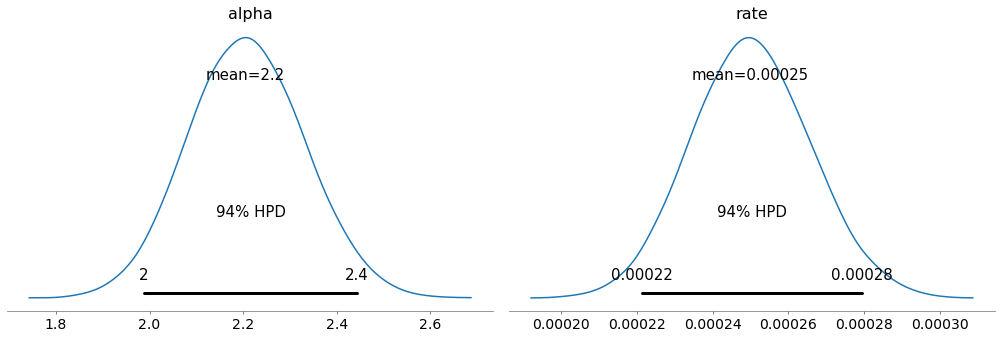

In [15]:
pm.plots.plot_posterior(trace)

Now, how do I get a histogram?.... searching

Found [PyMC3 Plotting](https://docs.pymc.io/api/plots.html)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1146afef0>,
      dtype=object)

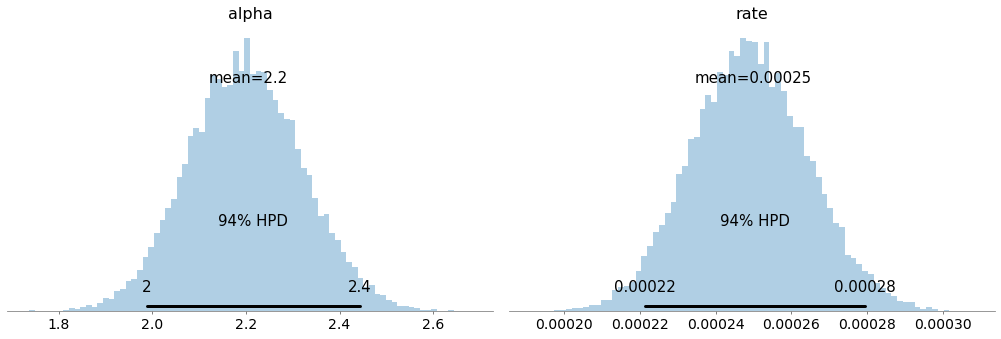

In [16]:
pm.plots.plot_posterior(trace, kind='hist')


> Mark your CIs on the histograms.

This comes for free with the function.

> Do they look okay? What would bad plots look like?

They look pretty and "normally distributed". I assume "bad plots" would look jaggy or have weird bumps.

----------------

__Q:__ Play around with some of the built-in diagnostic plots for your model. We suggest at least checking out the traceplot for alpha and beta. How do they look?

__A:__ ref: [Bayesian Modeling Cookbook](https://eigenfoo.xyz/bayesian-modelling-cookbook/)

<blockquote>
    In addition to the traceplot, there are a ton of other plots you can make with your trace:

   * `pm.plot_posterior(trace)`: check if your posteriors look reasonable.
   * `pm.forestplot(trace)`: check if your variables have reasonable credible intervals, and Gelman–Rubin scores close to 1.
   * `pm.autocorrplot(trace`): check if your chains are impaired by high autocorrelation. Also remember that thinning your chains is a waste of time at best, and deluding yourself at worst. See Chris Fonnesbeck’s comment on this GitHub issue and Junpeng Lao’s reply to Michael Betancourt’s tweet
   * `pm.energyplot(trace)`: ideally the energy and marginal energy distributions should look very similar. Long tails in the distribution of energy levels indicates deteriorated sampler efficiency.
   * `pm.densityplot(trace`): a souped-up version of pm.plot_posterior. It doesn’t seem to be wildly useful unless you’re plotting posteriors from multiple models.

PyMC3 has a nice helper function to pretty-print a summary table of the trace: `pm.summary(trace)` (I usually tack on a `.round(2)` for my sanity).
</blockquote>


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1145b2320>,
      dtype=object)

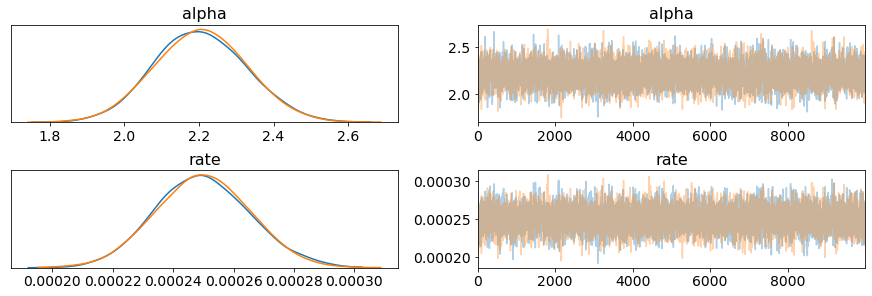

In [17]:
pm.traceplot(trace)

(<Figure size 432x388.8 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x121cdf978>],
       dtype=object))

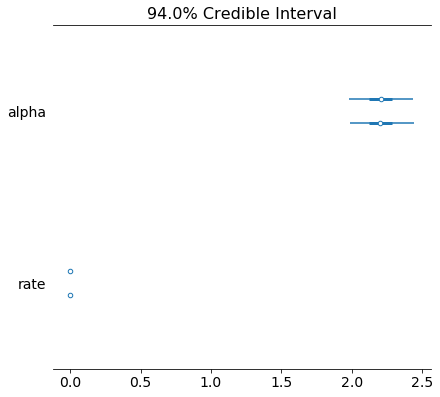

In [18]:
pm.forestplot(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121da5278>,
      dtype=object)

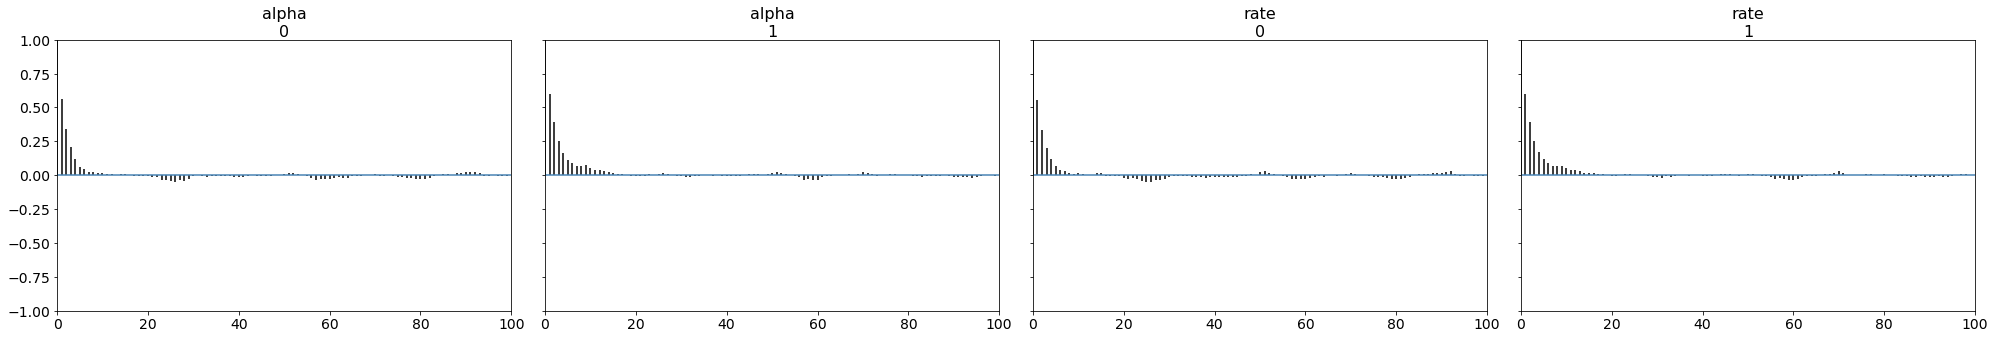

In [19]:
pm.autocorrplot(trace)

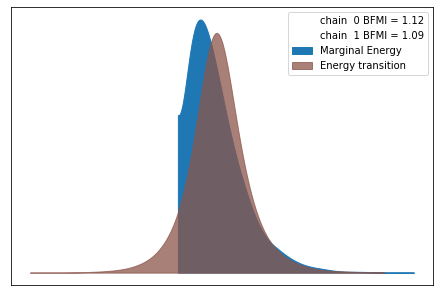

In [20]:
pm.energyplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x114e77fd0>,
      dtype=object)

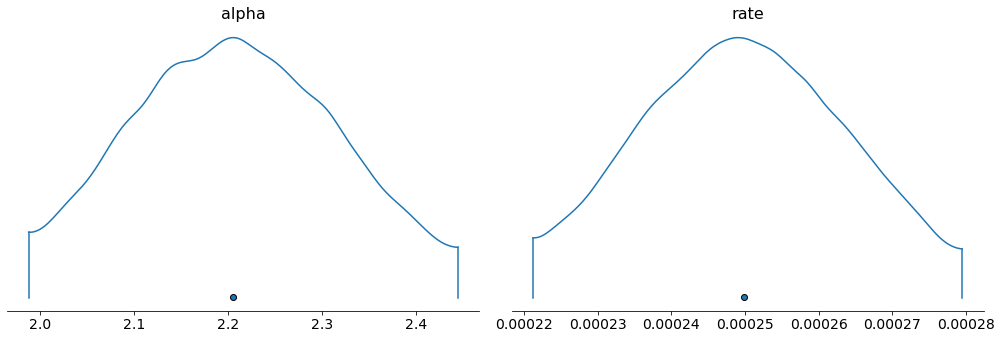

In [21]:
pm.densityplot(trace)

In [22]:
pm.summary(trace).round(2)

/Local/Users/vlb/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,2.21,0.12,0.0,1.97,2.45,4477.78,1.0
rate,0.00,0.00,0.0,0.00,0.00,4499.77,1.0


<hr style="border: 2px solid green;">


__Q:__ Take your best shot at a new simulated sequence of medical charges using scipy.stat's gamma distribution. Don't forget the difference between functions that take $\beta$ and functions that use $1/\beta$ for the scale parameter. Simulate a data set the same size as the number of observations in the data and overlay the two histograms (simulated and observed).

__A:__

In [23]:
# alpha_est = np.mean(no_insurance)**2 / np.var(no_insurance)
# beta_est = np.var(no_insurance) / np.mean(no_insurance)

# Simulate a data set the same size as the number of observations in the data
simulated = gamma.rvs(alpha_est, scale = beta_est,  size = len(no_insurance)) 


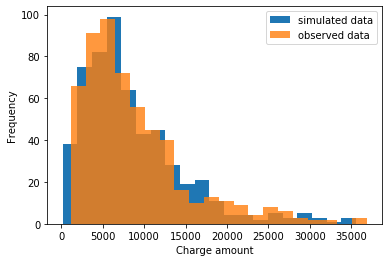

In [24]:
seed(47)
_ = plt.hist(simulated, bins=20, label='simulated data')
_ = plt.hist(no_insurance, bins=20, alpha=0.8, label='observed data')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

## Summary

In this exercise, we have postulated a distribution to describe the individual charge amounts for non-insured cases. This distribution has two required parameters, which we do not know, but we used PyMC3 to perform Bayesian inference to find our level of "belief" in a range of values for them. We then used the average parameter values to create one simulated data set of the same size as the original, but the distribution of our posteriors for these parameters will allow us to perform simulations of any sample size we desire and for a range of scenarios of different $\alpha$ and $\beta$. This could be a powerful tool to model different financial conditions for the hospital. 

Well done making it through this tricky subject. Starting think Bayesian _and_ starting to get to grips with something like PyMC3 is no easy task. As a data scientist, the most important thing is to be aware that this statistical approach exists, though you may not actually use this approach as much as you use the other approaches you've learned about. Still, we encourage you to think of ways that this approach could apply to the work that you do in this course and throughout your career.  